sos_ecor_wind_comparison - 

add wind speed, 

change sublimation rate back to latent heat flux, 

M-O approaches to latent heat flux, 

find downvalley and up valley potential temps (Schofield pass SNOTEL) and note elevation of each

SCHOFIELD PASS SNOTEL STATION: 737

In [1]:
import os
import act
import glob
import xarray as xr

import sys
sys.path.append('/home/elilouis/sublimationofsnow')
import sosutils
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import altair as alt
import ftplib
import pytz
import datetime
import metpy
from metpy.units import units
import pint_xarray
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# User Inputs

## SOS

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# datelist = ['20221031', '20221101', '20221102']
datelist = ['20221215', '20221216', '20221217', '20221218', '20221219']
start_date = datelist[0]
end_date = datelist[-1]


VARIABLE_NAMES = [  
    'spd_1m_c',     'dir_1m_c',     'u_1m_c',   'v_1m_c',   'w_1m_c',   'u_w__1m_c',    'v_w__1m_c',  'u_tc__1m_c',  'v_tc__1m_c',   'u_h2o__1m_c',  'v_h2o__1m_c',   'w_tc__1m_c',   'w_h2o__1m_c',
    'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',
    
    'tc_1m_c', 'tc_2m_c', 'tc_3m_c', 'tc_5m_c', 'tc_10m_c', 'tc_15m_c', 'tc_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c',
    'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c',
    'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c'
]



## ECOR

In [3]:
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
met_kp = 'gucmetS3.b1'

# start_date = '2022-10-31'
# end_date = '2022-11-02'
start_date = '20221215'
end_date = '20221219'

output_dir = '/data2/elilouis/sublimationofsnow/'
ecor_gothic_path = os.path.join(output_dir, ecor_gothic)
ecor_kp_path = os.path.join(output_dir, ecor_kp)
met_gothic_path = os.path.join(output_dir, met_gothic)
met_kp_path = os.path.join(output_dir, met_kp)

In [4]:
ecor_gothic_path,ecor_kp_path,met_gothic_path,met_kp_path

('/data2/elilouis/sublimationofsnow/guc30ecorM1.b1',
 '/data2/elilouis/sublimationofsnow/guc30ecorS3.b1',
 '/data2/elilouis/sublimationofsnow/gucmetM1.b1',
 '/data2/elilouis/sublimationofsnow/gucmetS3.b1')

In [5]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Data Download

## SOS

In [6]:
example_dataset = xr.open_dataset(sosutils.download_sos_data_day(datelist[0], sos_download_dir))

In [7]:
datasets = [xr.open_dataset(sosutils.download_sos_data_day(date, sos_download_dir))[VARIABLE_NAMES] for date in datelist]

sos_ds = sosutils.merge_datasets_with_different_variables(datasets, dim='time')
sos_df = sos_ds.to_dataframe().reset_index()

## ECOR

In [8]:
from tempfile import TemporaryDirectory
with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ecor_gothic,    start_date,    end_date,
        output = temp_dir
    )
    ecor_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    ecor_kp,    start_date,    end_date,
        output = temp_dir
    )
    ecor_kps_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

with TemporaryDirectory() as temp_dir:
    act.discovery.download_data(
        username,    token,    met_gothic,    start_date,    end_date,
        output = temp_dir
    )
    met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(temp_dir, '*.cdf')))

[DOWNLOADING] guc30ecorM1.b1.20221215.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221216.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221217.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221218.000000.cdf
[DOWNLOADING] guc30ecorM1.b1.20221219.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221215.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221216.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221217.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221218.000000.cdf
[DOWNLOADING] guc30ecorS3.b1.20221219.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221215.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221216.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221217.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221218.000000.cdf
[DOWNLOADING] gucmetM1.b1.20221219.000000.cdf


# Calculations

## Potential temperatures

In [9]:
met_gothic_ds['potential temperature'] \
                        = metpy.calc.potential_temperature(met_gothic_ds['atmos_pressure'] * units.kPa, met_gothic_ds['temp_mean'] * units.celsius).pint.to(units.celsius)

for i in range(1,21):
    sos_ds[f'Tpot_{i}m_c']     = metpy.calc.potential_temperature(sos_ds['P_10m_c'] * units.millibar, sos_ds[f'T_{i}m_c'] * units.celsius).pint.to(units.celsius)


## Sublimation/evaporation

In [10]:
ecor_kps_ds['sublimation rate (mm/hr)'] = 3600*ecor_kps_ds['lv_e']/2.838e6
ecor_gothic_ds['sublimation rate (mm/hr)'] = 3600*ecor_gothic_ds['lv_e']/2.838e6
sos_ds['sublimation rate (mm/hr)'] = 3600*sos_ds['w_h2o__3m_c']/1e3
sos_ds['lv_e'] = (sos_ds['w_h2o__3m_c']/1e3)*2.838e6

# Plot wind dir, pot. temps, and moisture fluxes at Gothic ad KPS sites

## Get nighttime df

In [11]:
import numpy as np
from matplotlib import dates

In [12]:
night_df = sosutils.get_nightime_df(
    'US/Mountain', 
    ecor_gothic_ds['lat'].values[0], 
    ecor_gothic_ds['lon'].values[0],
    [datetime.datetime.strptime(date_str, '%Y%m%d') for date_str in ecor_gothic_ds.attrs['_file_dates']]
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


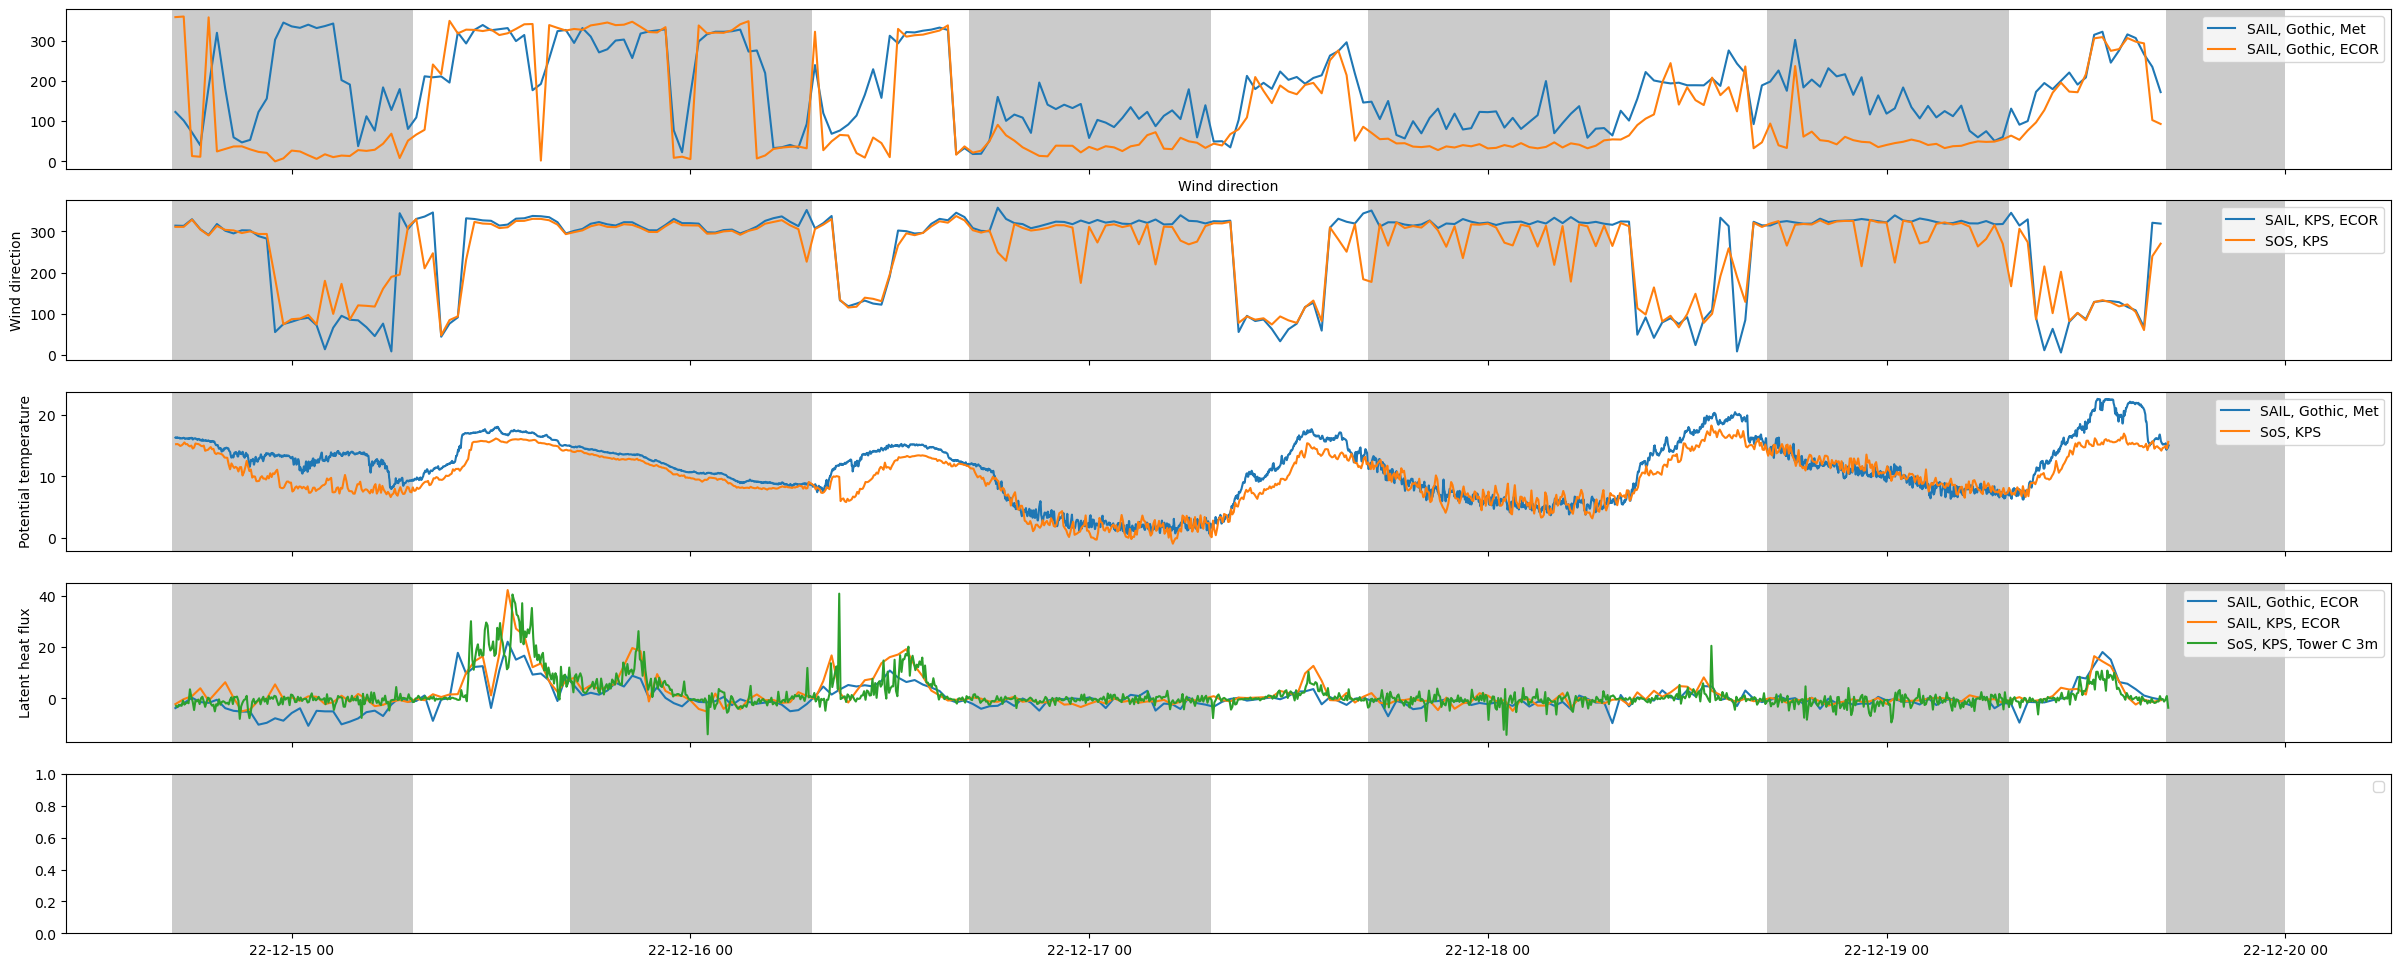

In [13]:
fig, axes = plt.subplots(5,1, figsize=(30,12), sharex=True)

met_gothic_ds_30min = met_gothic_ds.resample(time='30Min').mean()
sos_ds_30min = sos_ds.resample(time='30Min').mean()

# get local_time zones
met_gothic_ds_30min = sosutils.modify_xarray_timezone(met_gothic_ds_30min, pytz.UTC, pytz.timezone('US/Mountain'))
met_gothic_ds = sosutils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
ecor_gothic_ds = sosutils.modify_xarray_timezone(ecor_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
ecor_kps_ds = sosutils.modify_xarray_timezone(ecor_kps_ds, pytz.UTC, pytz.timezone('US/Mountain'))
sos_ds_30min = sosutils.modify_xarray_timezone(sos_ds_30min, pytz.UTC, pytz.timezone('US/Mountain'))
sos_ds = sosutils.modify_xarray_timezone(sos_ds, pytz.UTC, pytz.timezone('US/Mountain'))


# plot
axes[0].plot(met_gothic_ds_30min.local_time, met_gothic_ds_30min['wdir_vec_mean'], label='SAIL, Gothic, Met')
axes[0].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['wind_dir'], label='SAIL, Gothic, ECOR')
axes[0].set_xlabel('Wind direction')

axes[1].plot(ecor_kps_ds.local_time, ecor_kps_ds['wind_dir'], label='SAIL, KPS, ECOR')
axes[1].plot(sos_ds_30min.local_time, sos_ds_30min['dir_3m_c'], label='SOS, KPS')
axes[1].set_ylabel('Wind direction')

axes[2].plot(met_gothic_ds.local_time, met_gothic_ds['potential temperature'], label='SAIL, Gothic, Met')
axes[2].plot(sos_ds.local_time, sos_ds['Tpot_3m_c'], label='SoS, KPS')
axes[2].set_ylabel('Potential temperature')

# axes[3].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['sublimation rate (mm/hr)'], label='SAIL, Gothic, ECOR')
# axes[3].plot(ecor_kps_ds.local_time, ecor_kps_ds['sublimation rate (mm/hr)'], label='SAIL, KPS, ECOR')
# axes[3].plot(sos_ds.local_time, sos_ds['sublimation rate (mm/hr)'], label='SoS, KPS, Tower C 3m')

axes[3].plot(ecor_gothic_ds.local_time, ecor_gothic_ds['lv_e'], label='SAIL, Gothic, ECOR')
axes[3].plot(ecor_kps_ds.local_time, ecor_kps_ds['lv_e'], label='SAIL, KPS, ECOR')
axes[3].plot(sos_ds.local_time, sos_ds['lv_e'], label='SoS, KPS, Tower C 3m')
axes[3].set_ylabel('Latent heat flux')

for ax in axes:
    ax.xaxis.set_major_formatter(dates.DateFormatter('%y-%m-%d %H'))
    ax.legend()
    for i,row in night_df.iterrows():
        ax.axvspan(row['sunset'], row['sunrise'], facecolor='0.2', alpha=0.25)

# Calculate nondimensional numbers

## **Obhukov Length**

$$ L = \frac{
  u_*^3 \overline{\theta_v}
}{
  k g \overline{w'\theta'_v}
}
$$

$u_*$ = local scale/shear velocity

$\overline{\theta_v} $ = virtual potential temperature (mean over reynolds-averaging period)

$ \overline{w'\theta'_v} $ = vertical turbulent flux of sensible heat (in terms of virtual potential temperature, mean over reynolds-averaging period)

$k$ = von kármán constant

$$ u_* = \sqrt{\frac{\overline{u'w'}}{\rho}} $$


$\overline{u'w'}$ = vertical turbulent flux of momentum (mean over reynolds-averaging period)

$\rho$ = air density

To calculate the shear velocity we need to rotate the coordinate system to point upstream.

### Rotate coordinate system for small period of time 

In [14]:
sliced_sos_ds = sos_ds.sel(time=slice('2022-12-16 22:00', '2022-12-17 00:00'))
tidy_df = sosutils.get_tidy_dataset(sliced_sos_ds, VARIABLE_NAMES)
tidy_streamwise_df = sosutils.streamwise_coordinates_single_rotation_tidy_df(tidy_df)

### Examine changes to dataset

In [15]:
alt.Chart(
    pd.concat([
        tidy_df.assign(coordinates='Sonic'),
        tidy_streamwise_df.assign(coordinates='Streamwise')
    ])
).transform_filter(
    alt.FieldOneOfPredicate('height', [1,2,3,5,10,15,20]) # limite to measurements at sonic heights
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('coordinates:N')
).properties(
    width=150,
    height=50
).facet(
    column = 'height:O',
    row = 'measurement'
).resolve_scale(y='independent')

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

### Calculate components of the Obukhov length with streamwise data

In [39]:
import metpy.constants
import metpy.calc
from metpy.units import units
import pint

In [40]:
tidy_streamwise_df.measurement.unique()

array(['wind speed', 'wind direction', 'u', 'v', 'w', 'u_w_', 'v_w_',
       'u_tc_', 'v_tc_', 'u_h2o_', 'v_h2o_', 'w_tc_', 'w_h2o_',
       'virtual temperature', 'temperature', 'pressure', 'RH'],
      dtype=object)

In [41]:
# Note that I need to use xarray datasets here for metpy/pint units and metpy functions work 
tidy_streamwise_indexed_df = tidy_streamwise_df.set_index(['time', 'tower', 'height', 'measurement',])

# We have pressure and temperature
pressure = xr.DataArray(tidy_streamwise_indexed_df.loc[:, 'c', 10, 'pressure']['value']) * units.millibar
temperature = xr.DataArray(tidy_streamwise_indexed_df.loc[:, 'c', 10, 'temperature']['value']) * units.celsius



# We need mixing ratio to calculate air density, which we can calculate with P, T, and Relative Humidity
#   see: http://www.atmo.arizona.edu/students/courselinks/fall12/atmo336/lectures/sec1/humidity.html
# Note: we need to convert RH to a fraction as it comes in percent units (ie .7 is 70.)
mixing_ratio = xr.DataArray(tidy_streamwise_indexed_df.loc[:, 'c', 10, 'RH']['value']/100) * metpy.calc.saturation_mixing_ratio(
    pressure,
    temperature
)
air_density = metpy.calc.density(pressure, temperature, mixing_ratio)

# Now calculate shear velocity
vertical_turb_momentum_flux = xr.DataArray(tidy_streamwise_indexed_df.loc[:, 'c', 10, 'u_w_']['value']) * units('m/s') * units('m/s')
shear_velocity = np.sqrt(
    vertical_turb_momentum_flux / air_density
)

# virtual_temperature = tidy_streamwise_indexed_df.loc[:, 'c', 10, 'virtual temperature']['value'] * units.celsius
# vertical_velocity_virtual_temperature_covariance = tidy_streamwise_indexed_df.loc[:, 'c', 10, 'w_tc_']['value'] * units('m/s') * units.celsius* units('m/s') * units.celsius


/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/pint/facets/numpy/numpy_func.py:307: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)


In [42]:
shear_velocity

Magnitude,[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Units,meter2.5/(kilogram0.5 second)


$ L = \frac{
  u_*^3 \overline{\theta_v}
}{
  k g \overline{w'\theta'_v}
}
$

$ u_* = \sqrt{\frac{\overline{u'w'}}{\rho}} $


In [43]:
import metpy.constants
import metpy.calc
from metpy.units import units

k = 0.4
g = metpy.constants.earth_gravity

pressure = sos_ds['P_10m_c'] * units.millibar
temperature = sos_ds['T_10m_c'] * units.celsius
virtual_temperature = sos_ds[f'tc_2m_c'] * units.celsius
covariance_term = sos_ds['w_tc__2m_c'] * units('m/s') * units.celsius



### Calculate variables for Obukhov length

In [44]:
tidy_streamwise_df.measurement.unique()

array(['wind speed', 'wind direction', 'u', 'v', 'w', 'u_w_', 'v_w_',
       'u_tc_', 'v_tc_', 'u_h2o_', 'v_h2o_', 'w_tc_', 'w_h2o_',
       'virtual temperature', 'temperature', 'pressure', 'RH'],
      dtype=object)

#### Calculate monin-obukhov length at 2m with central tower data

In [ ]:
tidy_streamwise_df.query("measurement == 'temperature'").query("height == 2").query("tower == 'c'")['value'] * units.celsius

In [ ]:
tidy_streamwise_df.query("measurement == 'potential temperature'").query("height == 2").query("tower == 'c'")['value'] * units.celsius

In [ ]:
pressure = tidy_streamwise_df.query("measurement == 'pressure'").query("height == 10").query("tower == 'c'")['value'] * units.millibar
temperature = tidy_streamwise_df.query("measurement == 'temperature'").query("height == 2").query("tower == 'c'")['value'] * units.celsius
virtual_temperature = sos_ds[f'tc_2m_c'] * units.celsius
covariance_term = sos_ds['w_tc__2m_c'] * units('m/s') * units.celsius

mixing_ratio = sos_ds['RH_2m_c']/100 * metpy.calc.saturation_mixing_ratio(
    pressure,
    temperature
)

density = metpy.calc.density(pressure, temperature, mixing_ratio)

# Sos data tidy and profile plots

In [ ]:
sos_tidy_temps = sos_ds[[f for f in sos_ds.data_vars if f.startswith('T_') or f.startswith('Tpot_')]]
sos_tidy_temps = sos_tidy_temps.resample(time='120Min').mean().to_dataframe().reset_index()

In [ ]:
sos_tidy_temps = sos_tidy_temps.melt(id_vars='time')
sos_tidy_temps['height'] = sos_tidy_temps['variable'].apply(sosutils.height_from_variable_name)
sos_tidy_temps['tower'] = sos_tidy_temps['variable'].apply(sosutils.tower_from_variable_name)
sos_tidy_temps['measurement'] = sos_tidy_temps['variable'].apply(sosutils.measurement_from_variable_name)


In [ ]:
alt.data_transformers.disable_max_rows()

In [ ]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'T'
).mark_line().encode(
    alt.X('value:Q', sort='-y'),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'))
).properties(
    width=50, 
    height=100
).resolve_scale(x='independent')

In [ ]:
alt.Chart(sos_tidy_temps).transform_filter(
    alt.datum.measurement == 'Tpot'
).mark_line().encode(
    alt.X('value:Q', sort='-y'),
    alt.Y('height:Q'),
    alt.Facet('time:T', header=alt.Header(format="%m/%d %H:00", formatType='time'))
).properties(
    width=50, 
    height=100
).resolve_scale(x='independent')